First, import all necessary libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from skyfield.api import load, EarthSatellite

pd.set_option('display.max_columns', None) #because truncated outputs help nobody


Then, convert the databases (currently in CSV format) to a pandas dataframe, and inner join them based on satellite NORAD id. The databases used are as follows:

1. Celestrak's Active Satellite Database - https://celestrak.org/NORAD/elements/table.php?GROUP=active&FORMAT=csv
2. The Union of Concerned Scientists (UCS) Satellite Database - https://www.ucsusa.org/resources/satellite-database 

In [2]:
celestrak = pd.read_csv('celestrak.csv') 
ucs = pd.read_csv('UCS.csv')
db = pd.merge(ucs, celestrak, left_on='NORAD Number', right_on='NORAD_CAT_ID', how="inner").reset_index()
db.columns

Index(['index', 'Name of Satellite, Alternate Names',
       'Current Official Name of Satellite', 'Country/Org of UN Registry',
       'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose',
       'Detailed Purpose', 'Class of Orbit', 'Type of Orbit',
       'Longitude of GEO (degrees)', 'Perigee (km)', 'Apogee (km)',
       'Eccentricity', 'Inclination (degrees)', 'Period (minutes)',
       'Launch Mass (kg.)', ' Dry Mass (kg.) ', 'Power (watts)',
       'Date of Launch', 'Expected Lifetime (yrs.)', 'Contractor',
       'Country of Contractor', 'Launch Site', 'Launch Vehicle',
       'COSPAR Number', 'NORAD Number', 'Comments', 'Unnamed: 28',
       'Source Used for Orbital Data', 'Source', 'Source.1', 'Source.2',
       'Source.3', 'Source.4', 'Source.5', 'Source.6', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnam

As a preliminary check, look for missing values in the database. Also, notice that certain columns are useless and/or duplicates, so remove them. 

In [3]:
check = db.copy()
db.drop(columns=["NORAD Number", "Name of Satellite, Alternate Names"], axis=1, inplace=True)

#the "unnamed" columns got added because excel is stupid; the source columns are irrelevant to this analysis
for i in db.columns:
    if "Unnamed" in i or "Source" in i:
        db.drop(i, axis=1, inplace=True)
    elif db[db.isna()[i]][i].size > db[i].size * 0.1:
        db.drop(i, axis=1, inplace=True)

Notice that the ELEMENT_SET_NO column is always 999. This column represents the number of times the data for that satellite has been updated; in this case, it's likely that the data has been updated more than the max the original data's format was capable of holding. Therefore, we can drop this column. Also notice that the CLASSIFICATION_TYPE column always has a value of U; this is because the only satellites whose data we have access to are unclassfied, and none of them will have any other value. Therefore, we can also drop this column. 

In [4]:
db.drop("ELEMENT_SET_NO", axis=1, inplace=True)
db.drop("CLASSIFICATION_TYPE", axis=1, inplace=True)

There are a couple of duplicate columns. Let's drop them. I'm choosing to drop the non-capitalized ones because I know the all-caps ones don't have any missing values. 

In [5]:
db.drop("Eccentricity", axis=1, inplace=True)
db.drop("Inclination (degrees)", axis=1, inplace=True)

Let's convert the strings in the dataframe, where possible, into floats:

In [6]:
db["Longitude of GEO (degrees)"] = db["Longitude of GEO (degrees)"].astype(float)
db['Perigee (km)'] = db['Perigee (km)'].str.replace(',', '').astype(float)
db["Perigee (km)"] = db["Perigee (km)"].astype(float)
db['Apogee (km)'] = db['Apogee (km)'].str.replace(',', '').astype(float)
db["Apogee (km)"] = db["Apogee (km)"].astype(float)
db["ECCENTRICITY"] = db["ECCENTRICITY"].astype(float)
db["Period (minutes)"] = db["Period (minutes)"].astype(float)
db['Launch Mass (kg.)'] = db['Launch Mass (kg.)'].str.replace(',', '').astype(float)
db["Launch Mass (kg.)"] = db["Launch Mass (kg.)"].astype(float)
db["Longitude of GEO (degrees)"] = db["Longitude of GEO (degrees)"].astype(float)
db.drop("index", axis=1, inplace=True)

Also, notice the format of the "EPOCH" and "Date of Launch" columns are fairly unusable. Let's try and convert them. 

In [7]:
db["EPOCH"] = pd.to_datetime(db["EPOCH"])
db.reset_index() #to make db.loc possible

#because there's at least one term with a '//'
for i in range(db["Date of Launch"].size):
    if "//" in db.loc[i, "Date of Launch"]:
        db.loc[i, "Date of Launch"] = db.loc[i, "Date of Launch"].replace("//", "/")

db["Date of Launch"] = pd.to_datetime(db["Date of Launch"])
db

,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.),Date of Launch,Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,LEO,Non-Polar Inclined,0.0,566.0,576.0,96.08,22.0,2019-12-11,Hera Systems,USA,Satish Dhawan Space Centre,PSLV,2019-089H,IHOPSAT-TD,2019-089H,2024-10-19 02:14:56.531904,15.058365,0.000622,36.9684,77.5033,306.3334,53.6836,0,44859,26644,0.000802,1.180000e-04,0.0
1,AAC AIS-Sat1 (Kelpie 1),United Kingdom,United Kingdom,AAC Clyde Space,Commercial,Earth Observation,LEO,Sun-Synchronous,0.0,637.0,654.0,95.00,4.0,2023-01-03,AAC Clyde Space,Sweden/UK/USA/Netherlands,Cape Canaveral,Falcon 9,2023-001DC,AAC-AIS-SAT1,2023-001DC,2024-10-19 11:01:03.327456,14.826559,0.001215,97.9884,357.5596,106.7616,253.4930,0,55107,8820,0.003110,2.510000e-04,0.0
2,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,75.0,35778.0,35793.0,1436.03,6330.0,2014-02-06,Space Systems/Loral,USA,Guiana Space Center,Ariane 5 ECA,2014-006A,ABS-2,2014-006A,2024-10-19 03:56:42.794880,1.002711,0.000380,0.0039,170.4980,32.4640,319.3043,0,39508,3924,0.000000,-8.800000e-07,0.0
3,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,-75.0,35700.0,35700.0,1436.10,1800.0,2016-06-15,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9,2016-038A,ABS-2A (MONGOLSAT-1),2016-038A,2024-10-17 11:55:26.169888,1.002679,0.000194,0.0234,230.6860,304.4061,104.9585,0,41588,3059,0.000000,-8.400000e-07,0.0
4,ABS-3A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,-3.0,35788.0,35803.0,1436.00,2000.0,2015-03-02,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9,2015-010A,ABS-3A,2015-010A,2024-10-17 14:59:05.664768,1.002698,0.000156,0.0125,148.8460,7.5155,92.0253,0,40424,3528,0.000000,-2.800000e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6253,Ziyuan 1-02C,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,763.0,773.0,100.20,1500.0,2011-12-22,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2011-079A,ZIYUAN 1-02C (ZY 1-02C),2011-079A,2024-10-19 11:02:24.000000,14.372148,0.000575,98.4850,0.2098,325.3552,229.2097,0,38038,67221,0.000844,2.470000e-05,0.0
6254,Ziyuan 1-2D,NR,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,748.0,758.0,99.80,2650.0,2019-09-14,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2019-059A,ZY-1 02D,2019-059A,2024-10-19 11:16:40.994688,14.353926,0.000252,98.3983,2.7047,118.5783,241.5657,0,44528,26744,0.000409,1.130000e-05,0.0
6255,Ziyuan 3,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,500.0,504.0,94.70,2650.0,2012-01-09,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2012-001A,ZIYUAN 3-1 (ZY 3-1),2012-001A,2024-10-19 09:13:54.837408,15.387869,0.000520,97.2292,353.0399,71.8107,288.3705,0,38046,70998,0.001730,6.680000e-04,0.0
6256,Ziyuan 3-2,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,487.0,500.0,94.49,2630.0,2016-05-29,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2016-033A,ZIYUAN 3-2 (ZY 3-2),2016-033A,2024-10-19 09:44:57.837408,15.211881,0.000751,97.4454,7.4891,211.1241,148.9551,0,41556,46588,0.001310,2.930000e-04

Looking at the dataframe above, it's notable that very few rows seem to have nonzero entries in the MEAN_MOTION_DDOT column, which represents the second derivative of the mean motion of each satellite, divided by 6. Let's, first, change each value to just simply be the second derivative of mean motion, and then find out what percent actually has a value in this column:

In [8]:
db["MEAN_MOTION_DDOT"] *= 6
repr(db[abs(db['MEAN_MOTION_DDOT']) != 0].size / db.size * 100) + \
"% - percent of satellites with the second derivative of mean motion not equal to 0"

'0.3515500159795462% - percent of satellites with the second derivative of mean motion not equal to 0'

The second derivative of mean motion is usually zero, and only nonzero in cases of significant significant perturbation or atmospheric drag. In theory, then, it would primarily affect satellites of low altitude, where the atmosphere is significantly more prevalent. To test that, it seems fairly reasonable to use Perigee (km) (the closest point in the orbit to the Earth) as a stand-in for altitude in this check, as that's where atmospheric drag will have the strongest impact. Updating the database, then, and splitting it into nonzero and zero distributions:

In [9]:
#splitting the database into two, satellites with nonzero and zero second derivative of mean motion
db.dropna(subset="Perigee (km)", inplace=True)
nonzero = db[abs(db['MEAN_MOTION_DDOT']) != 0].reset_index().drop(columns=['index'])
zero = db[abs(db["MEAN_MOTION_DDOT"]) == 0].reset_index().drop(columns=["index"])

Setting up a hypothesis test comes next:

<b>Null Hypothesis</b> - The Perigee (km) distribution of satellites with nonzero second derivative of mean motion is not lower than the Perigee (km) distribution of satellites with zero second derivative of mean motion. 

<b>Alternative Hypothesis</b> - The Perigee (km) distribution of satellites with nonzero second derivative of mean motion is lower than the Perigee (km) distribution of satellites with zero second derivative of mean motion. 

Since the guess is that a lower altitude will lead to nonzero second derivative of mean motion, this is a <b>one-tailed</b> test - the lower tail. Also, since the data for the nonzero group is indepenent of the zero group - there is no explicit relationship between the groups - and, unfortunately, not likely to be normally distributed - the sample size is only 36, barely meeting that criteria, and satellites tend to cluster around certain orbits instead of being randomly placed - this calls for a nonparametric hypothesis test. I'm choosing to use the <b>Mann-Whitney U</b> test. The significance level will be α = 0.05. 

In [10]:
_, p = stats.mannwhitneyu(nonzero['Perigee (km)'], zero['Perigee (km)'], alternative='less')
print("p-value: %.10E" % p)

p-value: 6.4461023785E-05


The p-value is clearly very small, indicating that the null hypothesis should be rejected; the theory is therefore accepted!

Let's plot this, now:

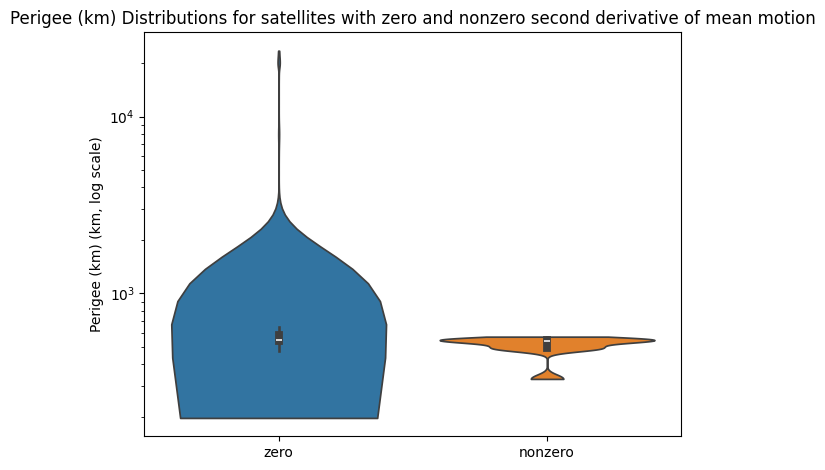

In [11]:
#cut out outliers to actually make the plots visible
top = zero["Perigee (km)"].std() * 2 + zero["Perigee (km)"].mean()
bottom = zero["Perigee (km)"].std() * -2 + zero["Perigee (km)"].mean()

#add relevant data to new dataframe
hm = pd.DataFrame()
hm['zero'] = zero[~zero['Perigee (km)'].isna() & (zero['Perigee (km)'] < top) & (zero['Perigee (km)'] > bottom)]['Perigee (km)']
hm['nonzero'] = nonzero[~ (nonzero['Perigee (km)'].isna())]['Perigee (km)']

#plot!
ax = sns.violinplot( data=hm, cut=0, bw_method=0.3)
ax.set_ylabel("Perigee (km) (km, log scale)")
ax.set_title("Perigee (km) Distributions for satellites with zero and nonzero second derivative of mean motion")
plt.tight_layout()
plt.yscale("log") #to make the ridiculous scales of space visible on a tiny screen
plt.show()

Note that the y-axis used is a log scale, as the distance values of satellites far away are exponentially higher than those in Low Earth Orbit. 

Notice the differences between the two distributions: the satellites in the nonzero group clearly don't have altitudes as high as those in the zero group. It's visual proof of the hypothesis testing result!

Alright, now back to the original data. Let's group the dataframe by the "Purpose" Column. 

In [12]:
grouped = db.groupby("Purpose").describe()
grouped

Longitude of GEO (degrees)  \
                                                                    count   
Purpose                                                                     
Communications                                                     5001.0   
Communications/Maritime Tracking                                      5.0   
Communications/Navigation                                             1.0   
Communications/Technology Development                                 4.0   
Earth Observation                                                   710.0   
Earth Observation                                                     3.0   
Earth Observation/Communications                                      2.0   
Earth Observation/Communications/Space Science                        1.0   
Earth Observation/Earth Science                                       1.0   
Earth Observation/Navigation                                          9.0   
Earth Observation/Space Science                                       1.0   
Earth Observation/Technology Development                              4.0   
Earth Science                                                        17.0   
Earth Science/Earth Observation                                       1.0   
Earth/Space Observation                                               1.0   
Meteorological                                                        6.0   
Mission Extension Technology                                          2.0   
Navigation/Global Positioning                                       133.0   
Navigation/Regional Positioning                                      12.0   
Platform                                                              1.0   
Satellite Positioning                                                 1.0   
Space Observation                                                     3.0   
Space Science                                                        73.0   
Space Science/Technology Demonstration                                1.0   
Surveillance                                                         18.0   
Technology Demonstration                                             46.0   
Technology Development                                              193.0   
Technology Development/Educational                                    2.0   

                                                                           \
                                                      mean    min     25%   
Purpose                                                                     
Communications                                    1.154917 -179.8   0.000   
Communications/Maritime Tracking                  0.000000    0.0   0.000   
Communications/Navigation                        55.000000   55.0  55.000   
Communications/Technology Development             6.250000    0.0   0.000   
Earth Observation                                 1.382648 -159.6   0.000   
Earth Observation                                 0.000000    0.0   0.000   
Earth Observation/Communications                 64.000000    0.0  32.000   
Earth Observation/Communications/Space Science    0.000000    0.0   0.000   
Earth Observation/Earth Science                   0.000000    0.0   0.000   
Earth Observation/Navigation                      0.000000    0.0   0.000   
Earth Observation/Space Science                   0.000000    0.0   0.000   
Earth Observation/Technology Development          0.000000    0.0   0.000   
Earth Science                                     0.000000    0.0   0.000   
Earth Science/Earth Observation                   0.000000    0.0   0.000   
Earth/Space Observation                           0.000000    0.0   0.000   
Meteorological                                    0.000000    0.0   0.000   
Mission Extension Technology                    165.750000  -27.5  69.125   
Navigation/Global Positioning                    15.873759    0.0   0.000   
Navigation/Regional Positioning           

Notice that there are many satellites that seem to fall into multiple categories. As an approximation, let's just assume the first category listed is the category of the satellite. Also, let's combine and rename a couple categories: 

Technology Demonstration and Technology Development as: Technology Development. <br>
Space Science and Space Observation as: Space Science. <br>
Satellite Positioning as Navigation. <br>
Earth as Earth Observation. 

In [13]:
db.reset_index(inplace=True)
#renaming
for i in range(db["Purpose"].size):
    if "/" in db.loc[i, "Purpose"]:
        hm = db.loc[i, "Purpose"]
        index = hm.index("/")
        db.loc[i, "Purpose"] = hm[:index]
    if db.loc[i, "Purpose"] == "Technology Demonstration":
        db.loc[i, "Purpose"] = "Technology Development"
    if db.loc[i, "Purpose"] == "Space Observation":
        db.loc[i, "Purpose"] = "Space Science"
    if db.loc[i, "Purpose"] == "Satellite Positioning":
        db.loc[i, "Purpose"] = "Navigation"
    if db.loc[i, "Purpose"] == "Earth" or "Earth Observation" in db.loc[i, "Purpose"]:
        #second part of the conditional is because there appears to be duplicate categories otherwise
        #and i can't figure out the difference between them
        db.loc[i, "Purpose"] = "Earth Observation"
grouped = db.groupby("Purpose").describe()
grouped

index                                        \
                               count         mean     min      25%     50%   
Purpose                                                                      
Communications                5012.0  3411.843575     2.0  2243.75  3496.5   
Earth Observation              732.0  2139.479508     0.0   533.75  1041.5   
Earth Science                   18.0   873.222222   212.0   414.75   576.5   
Meteorological                   6.0  5976.500000  5974.0  5975.25  5976.5   
Mission Extension Technology     2.0  1126.500000  1126.0  1126.25  1126.5   
Navigation                     146.0   659.602740   122.0   158.25   519.5   
Platform                         1.0   466.000000   466.0   466.00   466.0   
Space Science                   77.0  2143.662338    44.0   750.00  1254.0   
Surveillance                    18.0   732.666667   701.0   705.25   709.5   
Technology Development         241.0  2403.489627    12.0   724.00  1951.0   

                                                            \
                                  75%     max          std   
Purpose                                                      
Communications                4749.25  6241.0  1585.469917   
Earth Observation             2143.25  6257.0  2282.306976   
Earth Science                  639.75  6223.0  1355.863847   
Meteorological                5977.75  5979.0     1.870829   
Mission Extension Technology  1126.75  1127.0     0.707107   
Navigation                    1158.75  6094.0   638.473098   
Platform                       466.00   466.0          NaN   
Space Science                 2099.00  6225.0  2037.709322   
Surveillance                   713.75  1135.0   100.528603   
Technology Development        2175.00  6226.0  2157.124682   

                             Longitude of GEO (degrees)                     \
                                                  count        mean    min   
Purpose                                                                      
Communications                                   5011.0    1.168577 -179.8   
Earth Observation                                 732.0    1.515956 -159.6   
Earth Science                                      18.0    0.000000    0.0   
Meteorological                                      6.0    0.000000    0.0   
Mission Extension Technology                        2.0  165.750000  -27.5   
Navigation                                        146.0   22.435205    0.0   
Platform                                            1.0    0.000000    0.0   
Space Science                                      77.0   -1.324675 -102.0   
Surveillance                                       18.0    0.000000    0.0   
Technology Development                            241.0    4.540041  -65.5   

                                                                          \
                                 25%     50%      75%    max         std   
Purpose                                                                    
Communications                 0.000    0.00    0.000  180.0   26.736994   
Earth Observation              0.000    0.00    0.000  165.9   24.324973   
Earth Science                  0.000    0.00    0.000    0.0    0.000000   
Meteorological                 0.000    0.00    0.000    0.0    0.000000   
Mission Extension Technology  69.125  165.75  262.375  359.0  273.296771   
Navigation                     0.000    0.00    0.000  160.0   45.620629   
Platform                       0.000    0.00    0.000    0.0         NaN   
Space Science                  0.000    0.00    0.000    0.0   11.623979   
Surveillance                   0.000    0.00    0.000    0.0    0.000000   
Technology Development         0.000    0.00    0.000  162.9   23.420939   

                             Perigee (km)                                   \
                                    count          mean      min       25%   
Purpose                                          

Some of the categories are still fairly small and fairly niche. Let's try and combine them with others:

Add Platform to Space Science. <br>
Add Mission Extension Technology to Technology Development. <br>
Add Surveillance, Meterological, and Earth Science to Earth Observation. <br>

In [14]:
db.drop("index", axis=1, inplace=True)
db.reset_index(inplace=True)
#renaming
for i in range(db["Purpose"].size):
    if db.loc[i, "Purpose"] == "Mission Extension Technology":
        db.loc[i, "Purpose"] = "Technology Development"
    if db.loc[i, "Purpose"] == "Platform":
        db.loc[i, "Purpose"] = "Space Science"
    if db.loc[i, "Purpose"] in ["Surveillance", "Meteorological", "Earth Science"]:
        db.loc[i, "Purpose"] = "Earth Observation"
grouped = db.groupby("Purpose")
grouped.describe()

index                                                \
                         count         mean    min      25%     50%      75%   
Purpose                                                                        
Communications          5012.0  3407.127893    2.0  2238.75  3491.5  4744.25   
Earth Observation        774.0  2103.952196    0.0   539.25  1013.5  2134.75   
Navigation               146.0   657.890411  122.0   158.25   519.5  1153.75   
Space Science             78.0  2118.500000   44.0   732.50  1248.5  2089.50   
Technology Development   243.0  2389.296296   12.0   723.50  1943.0  2168.50   

                                            Longitude of GEO (degrees)  \
                           max          std                      count   
Purpose                                                                  
Communications          6236.0  1584.926419                     5011.0   
Earth Observation       6252.0  2270.877182                      774.0   
Navigation              6089.0   636.884195                      146.0   
Space Science           6220.0  2032.157179                       78.0   
Technology Development  6221.0  2150.010610                      243.0   

                                                                           \
                             mean    min  25%  50%  75%    max        std   
Purpose                                                                     
Communications           1.168577 -179.8  0.0  0.0  0.0  180.0  26.736994   
Earth Observation        1.433695 -159.6  0.0  0.0  0.0  165.9  23.657407   
Navigation              22.435205    0.0  0.0  0.0  0.0  160.0  45.620629   
Space Science           -1.307692 -102.0  0.0  0.0  0.0    0.0  11.549226   
Technology Development   5.866872  -65.5  0.0  0.0  0.0  359.0  32.644486   

                       Perigee (km)                                          \
                              count          mean    min       25%      50%   
Purpose                                                                       
Communications               5012.0   3634.601157  198.0    538.00    548.0   
Earth Observation             774.0   2253.830749  241.0    517.00    571.0   
Navigation                    146.0  23942.335616  523.0  20149.25  21515.5   
Space Science                  78.0   2050.384615  258.0    534.50    587.5   
Technology Development        243.0   3086.950617  240.0    515.00    572.0   

                                                       Apogee (km)  \
                             75%      max          std       count   
Purpose                                                              
Communications            580.00  37782.0  9837.557540      5012.0   
Earth Observation         690.00  35897.0  7404.583464       774.0   
Navigation              23457.25  35796.0  6514.550165       146.0   
Space Science             682.00  35779.0  5409.685480        78.0   
Technology Development    686.50  36097.0  8999.874603       243.0   

                                                                         \
                                mean    min      25%      50%       75%   
Purpose                                                                   
Communications           3769.099561  280.0    541.0    561.0    600.00   
Earth Observation        2563.785530   49.0    535.0    591.5    703.75   
Navigation              24359.246575  536.0  20215.0  21561.0  23570.25   
Space Science           21544.525641  422.0    569.5    632.5    800.00   
Technology Development   3548.230453  460.0    545.5    601.0    790.00   

                                               Period (minutes)              \
                             max           std            count        mean   
Purpose                                                                       
Communications          353798.0  11140.557074           5007.0  211.197695   
Earth Observation        39754.0   8070.232320            757.0

Now that we have 5 decently sized groups, let's find a way to visualize this. 

Because I'm bored, I'm going to try and plot the mean orbit of each category. 

Some basic orbital mechanics, first. There are 6 orbital elements by which all orbits can be uniquely characterized: 

Inclination (in degrees) <br>
Mean Motion (in revolutions per day) <br>
Right Ascension of the Ascending Node (in degrees)<br>
Eccentricity<br>
Argument of Pericenter / Perigee (in degrees)<br>
Mean Anomaly (in degrees)<br>

Ignore what each means, it doesn't matter. Also important is the TLE (two-line element) format. Celestrak's primary data storage is actually in TLEs, but they also have CSVs, which is what I've chosen to use. But TLEs are two-line objects that contain all the important information about a satellite and its orbit. They're important because the Skyfield library, which I'm going to use to generate time-varying orbital positions, takes TLEs as inputs. 

Note that in the below visualization, the blue dot at the center represents the Earth (not to scale!). 

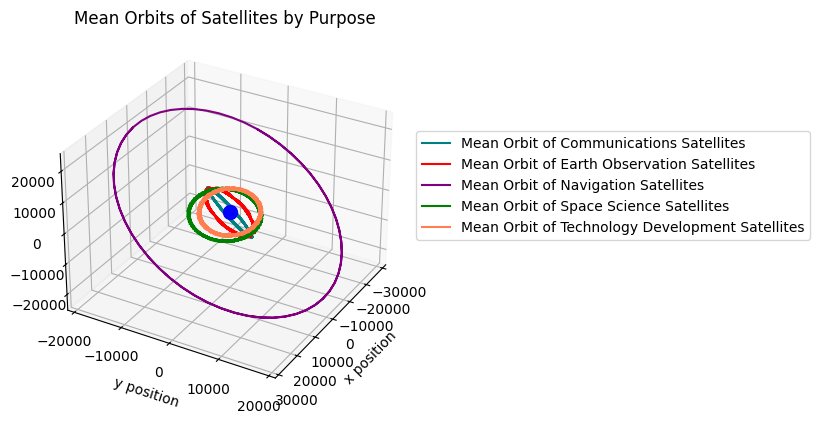

In [15]:
ts = load.timescale() #set time=0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
grouped = db.groupby(by="Purpose")
colors = ['coral', 'green', 'purple', 'red', 'teal'] #colors for the orbits (kind of aesthetic?)
#loop through the different purpose categories
for name, data in grouped:
    #calculate means per category of all orbital elements
    mean_inclination = data["INCLINATION"].mean()
    mean_motion = data["MEAN_MOTION"].mean()
    mean_raan = data["RA_OF_ASC_NODE"].mean()
    mean_ecc = data["ECCENTRICITY"].mean()
    mean_arg_perigee = data["ARG_OF_PERICENTER"].mean()
    mean_anomaly = data["MEAN_ANOMALY"].mean()

    #create the TLE
    tle_line_1 = f"1 00000U 00000AAA 21265.73525694 +.00002124  +00000-0  +50000-4 0 9995"
    tle_line_2 = f"2 00000 {mean_inclination:8.4f} {mean_raan:8.4f} {(mean_ecc*10**7):07.0f} {mean_arg_perigee:8.4f} {mean_anomaly:8.4f} {mean_motion:11.8f} 00000 "
    checksum = 0
    for i in tle_line_2:
        if not i == " " and not i == ".":
            checksum += int(i)
    tle_line_2 += str(checksum % 10)
    
    #Use Skyfield to create a satellite object
    satellite = EarthSatellite(tle_line_1, tle_line_2, f"Mean Orbit for category {name}", ts)

    #generate time-varying position, and add to plot
    t = ts.utc(2024, 10, np.arange(0, 1, 0.01))
    geocentric = satellite.at(t)
    x, y, z = geocentric.position.km
    ax.plot(x, y, z, label=f"Mean Orbit of {name} Satellites", color=colors.pop())

ax.legend(loc='upper left', bbox_to_anchor=(1, 0.75))
ax.view_init(elev=30, azim=30) #change viewpoint to make all orbits visible-ish
ax.scatter(0, 0, 0, s=100, color='blue') #create the Earth, not to scale
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Mean Orbits of Satellites by Purpose")
plt.show()

The conclusion here is the following: 

1. We can, fairly easily, classify all active major satellites into 5 categories. <br>
2. The orbits for each category can vary greatly, just purely by visual examination. 

Cool. Now back to the original dataset. 

Another interesting column could be the "Date of Launch" Column. Let's look at some summary statistics for it. 

In [16]:
db["Date of Launch"].describe()

count                             6253
mean     2020-02-20 07:58:18.672636928
min                1974-11-15 00:00:00
25%                2020-03-18 00:00:00
50%                2021-07-01 00:00:00
75%                2022-08-12 00:00:00
max                2023-04-27 00:00:00
Name: Date of Launch, dtype: object

Based on that, it appears that a vast majority of the satellites in the UCS database were launched during and post-COVID, which is interesting. 

It might be interesting to see if the year of launch has any correlation with a technological characteristic, such as launch mass. 

In [17]:
db["Year of Launch"] = db["Date of Launch"].dt.year
years = db[~db["Year of Launch"].isna()]["Year of Launch"].sort_index() #sorts shouldn't have any impact as they'll keep their indices from the dataframe
mass = db[~db["Launch Mass (kg.)"].isna()]["Launch Mass (kg.)"].sort_index()
correlation, p = stats.pearsonr(years[:min(years.size, mass.size)], mass[:min(years.size, mass.size)]) #used this instead of db.corr() because it gives a p-value
print(f"Correlation Coefficient: {correlation}; p-value: {p}")

Correlation Coefficient: -0.30320998729280546; p-value: 2.1232059721016904e-129


There is! The p-value, which in this case represents the possibility of an uncorrelated relationship given the data, is extremely low, which indicates a correlation of some significance. And here, the correlation doesn't seem to be particularly strong, but it is unmistakably a slight negative correlation. 

This seems to indicate that as time progresses, lighter and lighter satellites get launched. And that makes sense, as as launching these satellites gets cheaper, lighter satellites are actually worth launching!

Let's plot this relationship:

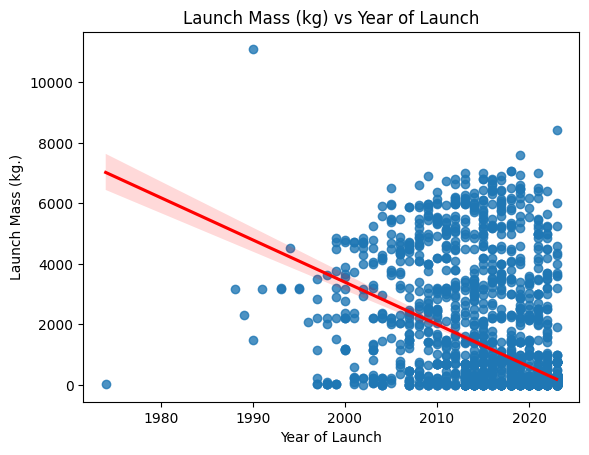

In [18]:
sns.regplot(data=db, x="Year of Launch", y="Launch Mass (kg.)", line_kws={"color":"red"})
plt.title("Launch Mass (kg) vs Year of Launch")
plt.show()

It's clearly not a particularly visible correlation, but if the math says it's there, I guess it's there. 



That should be three conclusions, then; bye!

Also, just an interesting note to finish this off: the heaviest satellite in the database is the Hubble Space Telescope!

In [19]:
db[db["Launch Mass (kg.)"] > 10000]

,index,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.),Date of Launch,Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,Year of Launch
746,746,Hubble Space Telescope,USA,ESA,European Space Agency (ESA)/NASA,Government,Space Science,LEO,Non-Polar Inclined,0.0,555.0,559.0,95.8,11110.0,1990-04-25,European Space Agency/NASA,International,Cape Canaveral,Space Shuttle (STS 31),1990-037B,HST,1990-037B,2024-10-18 21:57:22.198464,15.203388,0.000273,28.4687,234.7642,308.3897,51.6451,0,20580,69586,0.000721,0.000163,0.0,1990
